In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

In [0]:
!mkdir output

In [8]:
# coding: utf-8

import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import tensorflow as tf


class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 1, 3))
    VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
    STYLE_IMAGE = 'stone_style.jpg'
    CONTENT_IMAGE = 'content300.jpg'
    OUTPUT_DIR = 'output/'

def load_vgg_model(path):
    """
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """

    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']

    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    graph = {}
    graph['input'] = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)),
                                 dtype='float32')
    graph['conv1_1'] = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2'] = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1'] = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2'] = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1'] = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2'] = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3'] = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4'] = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1'] = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2'] = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3'] = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4'] = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1'] = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2'] = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3'] = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4'] = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])

    return graph

def generate_noise_image(content_image, noise_ratio=CONFIG.NOISE_RATIO):

    noise_image = np.random.uniform(-20, 20,
                                    (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype(
        'float32')

    
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image

def reshape_and_normalize_image(image):

    image = np.reshape(image, ((1,) + image.shape))

    
    image = image - CONFIG.MEANS

    return image

def save_image(path, image):
    
    image = image + CONFIG.MEANS

    
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)


model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)


def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(tf.transpose(a_C,perm=[0,3,1,2]),[n_C,n_H*n_W])
    
    a_G_unrolled = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),[n_C,n_H*n_W])
    
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/4/n_H/n_W/n_C
    
    
    return J_content

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,A,transpose_b=True)
    
    
    return GA

def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_S = tf.reshape(tf.transpose(a_S,perm=[0,3,1,2]),[n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),[n_C,n_H*n_W])

    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/4/n_H**2/(n_W*n_C)**2
    
    
    
    return J_style_layer


STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]


def compute_style_cost(model, STYLE_LAYERS):

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)

        a_G = out
        
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        
        J_style += coeff * J_style_layer

    return J_style

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha*J_content + beta*J_style
    
    
    return J

tf.reset_default_graph()


sess = tf.InteractiveSession()

content_image = scipy.misc.imread("louvre.jpg")
content_image = reshape_and_normalize_image(content_image)
style_image = scipy.misc.imread("monet.jpg")
style_image = reshape_and_normalize_image(style_image)
generated_image = generate_noise_image(content_image)

model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

sess.run(model['input'].assign(content_image))

out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content,J_style)
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

def model_nn(sess, input_image, num_iterations = 200):
    
    
    
    sess.run(tf.global_variables_initializer())
    
    
    
    
    sess.run(model['input'].assign(input_image))
    
    
    for i in range(num_iterations):
    
        
        
        sess.run([train_step, J])
        
        
        
        
        generated_image = sess.run(model['input'])
        

        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

model_nn(sess, generated_image)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

array([[[[ -46.104897  ,   -2.591183  ,   24.741594  ],
         [ -36.911312  ,  -28.195303  ,    1.3434873 ],
         [ -60.313103  ,  -19.00218   ,    0.19008666],
         ...,
         [   0.36463168,  -35.477615  ,   46.643547  ],
         [  -5.6199455 ,  -45.4671    ,   44.952526  ],
         [ -21.996271  ,  -18.018978  ,   33.694134  ]],

        [[ -39.52525   ,    7.7997103 ,   56.418053  ],
         [ -23.983673  ,   -4.383984  ,   27.69253   ],
         [ -15.668785  ,  -10.016811  ,   27.797184  ],
         ...,
         [  31.437035  ,  -48.544304  ,   -2.828689  ],
         [  32.73324   ,  -40.98559   ,   16.148794  ],
         [ -14.85311   ,  -28.74101   ,   48.577023  ]],

        [[ -42.353794  ,   -4.7032847 ,   40.655064  ],
         [ -35.20861   ,   -4.276322  ,    6.341651  ],
         [ -26.178415  ,   -8.630758  ,  -10.068432  ],
         ...,
         [  32.825005  ,  -51.00683   ,   17.115406  ],
         [  11.351456  ,  -33.958553  ,   17.676144  ],
  

In [6]:
from google.colab import files

uploaded = files.upload() # then browse, select the files. It's then uploaded

# uploaded is now a dict containing "filename" -> Content

Saving imagenet-vgg-verydeep-19.mat to imagenet-vgg-verydeep-19.mat


In [7]:
!ls

datalab  imagenet-vgg-verydeep-19.mat  louvre.jpg  monet.jpg  output


In [44]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3878992619647078904
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11287966516
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18231755766455310042
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [46]:
import matplotlib
print(matplotlib.__version__)

2.1.2


In [10]:
!ls output

0.png	 120.png  160.png  20.png  60.png  generated_image.jpg
100.png  140.png  180.png  40.png  80.png


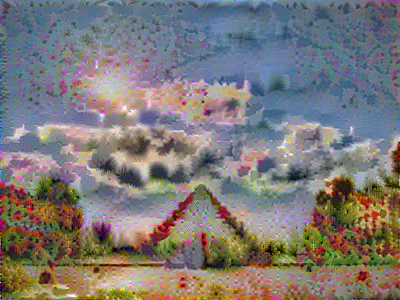

In [11]:
from IPython.display import Image
Image('output/140.png')